In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

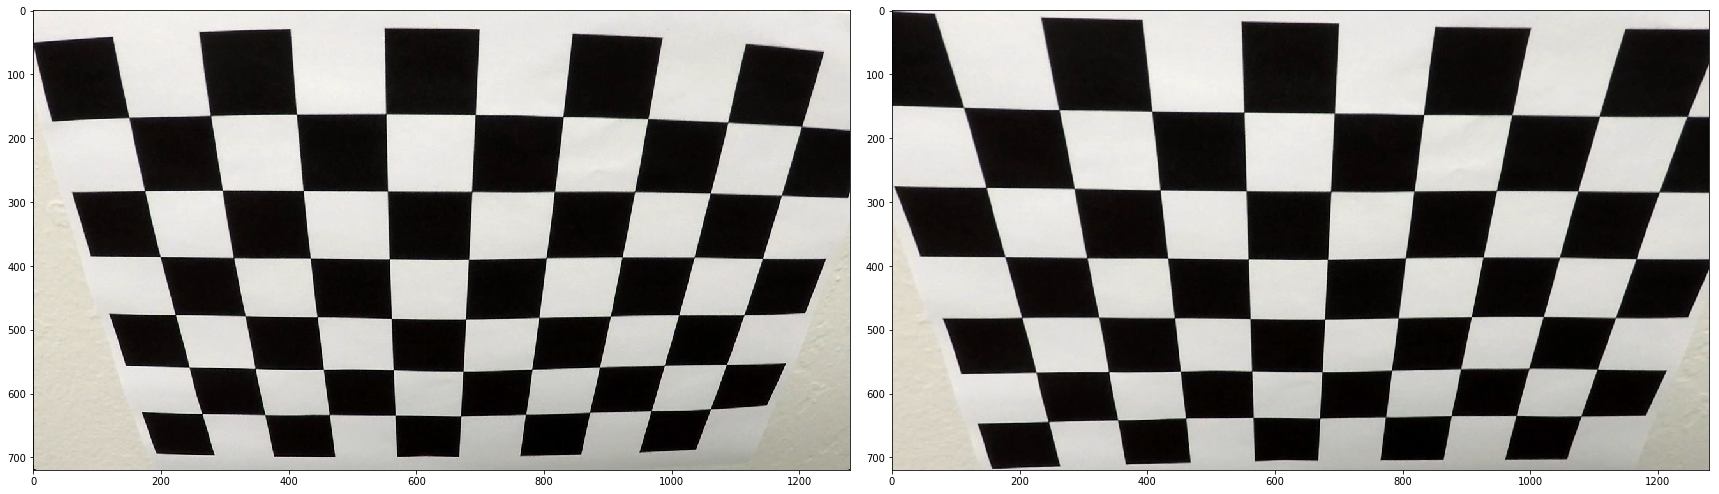

In [2]:
#import all images
images = glob.glob('camera_cal/calibration*.jpg')

#create empty arrays for obj and img points
objpoints = []
imgpoints = []

#prepare obj points and initialize as zeros
nx = 9
ny = 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

#loop through imainges and find corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

#find calibrated values via calibrate function
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

test_dist_image_cal  = mpimg.imread('camera_cal/calibration2.jpg')
test_dist_image__cal_undist = cv2.undistort(test_dist_image_cal, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_dist_image_cal)
ax2.imshow(test_dist_image__cal_undist)

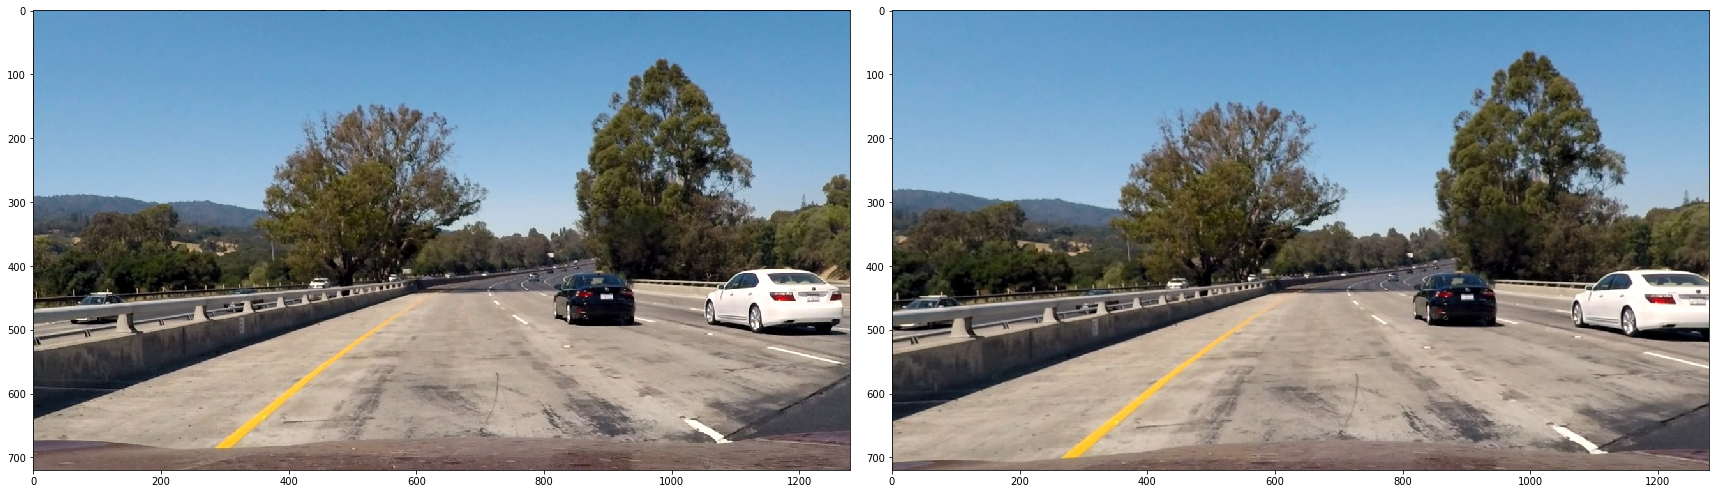

In [3]:
test_dist_image  = mpimg.imread('test_images/test1.jpg')
test_dist_image_undist = cv2.undistort(test_dist_image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_dist_image)
ax2.imshow(test_dist_image_undist)

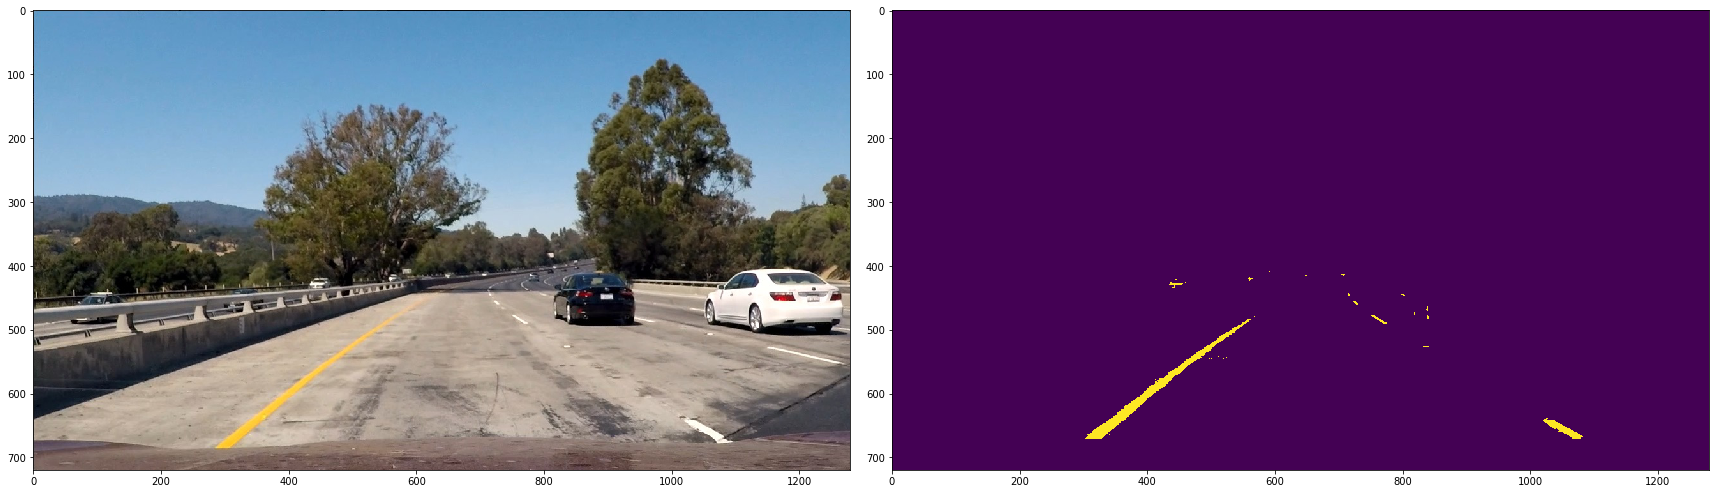

In [4]:
def create_binary(img):
    #create workign copy
    working_image = np.copy(img)
    imshape = working_image.shape

    #apply RGB threshold
    lower_yellow = np.array([150,150,0])
    upper_yellow = np.array([255,255,130])
    mask_yellow = cv2.inRange(working_image,lower_yellow,upper_yellow)

    lower_white = np.array([200,200,200])
    upper_white = np.array([255,255,255])
    mask_white = cv2.inRange(working_image,lower_white,upper_white)

    combined = mask_yellow + mask_white

    #create and apply mask
    mask = np.zeros_like(combined)
    ignore_mask_color = (255,)*3

    #only use pixels from area of interest
    vertices = np.array([[(100,imshape[0]-50),(450, 400), (750, 400), (1200,imshape[0]-50)]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    final = cv2.bitwise_and(combined, mask)
    
    return final, mask_yellow, mask_white

test_binary_input  = mpimg.imread('test_images/test1.jpg')
test_binary_output = create_binary(test_binary_input)[0]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_binary_input)
ax2.imshow(test_binary_output)

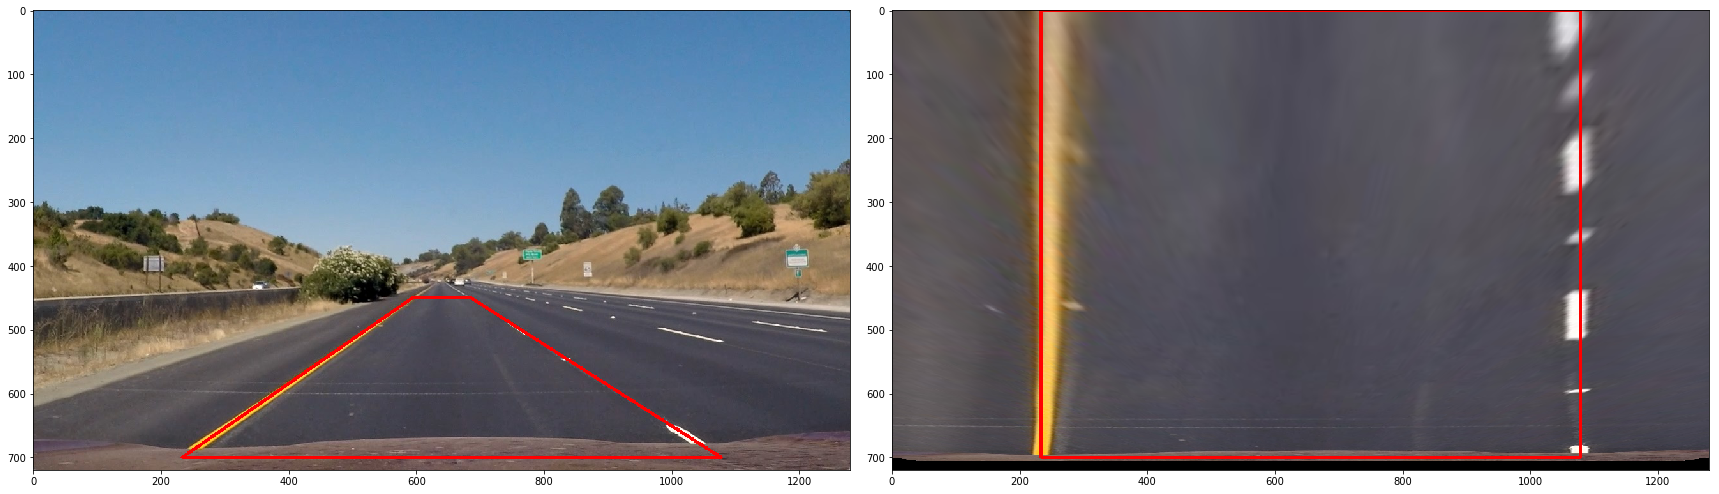

In [5]:
#apply to raw undistorted straight line
def warp(img):
    #use points from straight lane image and plot to bird's eye view
    img_size = (img.shape[1], img.shape[0])
    #points on unwarped image
    src = np.float32(        
    [[594,450],
    [686,450],
    [233,700],
    [1078,700]])
    #points on final "bird's eye view"
    dst = np.float32(
    [[233,0],
    [1078,0],
    [233,700],
    [1078,700]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def reverse_warp(img):
    img_size = (img.shape[1], img.shape[0])
    dst = np.float32(        
    [[594,450],
    [686,450],
    [233,700],
    [1078,700]])
    src = np.float32(
    [[233,0],
    [1078,0],
    [233,700],
    [1078,700]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

test_warp_input  = mpimg.imread('test_images/straight_lines1.jpg')
shape1 = np.array([[[594,450],[233,700],[1078,700],[686,450]]], np.int32)
test_warp_input_1 = cv2.polylines(test_warp_input, [shape1], True, (255,0,0),3)

test_warp_input_2  = mpimg.imread('test_images/straight_lines1.jpg')
test_warp_output = warp(test_warp_input_2)
shape2 = np.array([[[233,0],[233,700],[1078,700],[1078,0]]], np.int32)
test_warp_output_1 = cv2.polylines(test_warp_output, [shape2], True, (255,0,0),3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_warp_input_1)
ax2.imshow(test_warp_output_1)

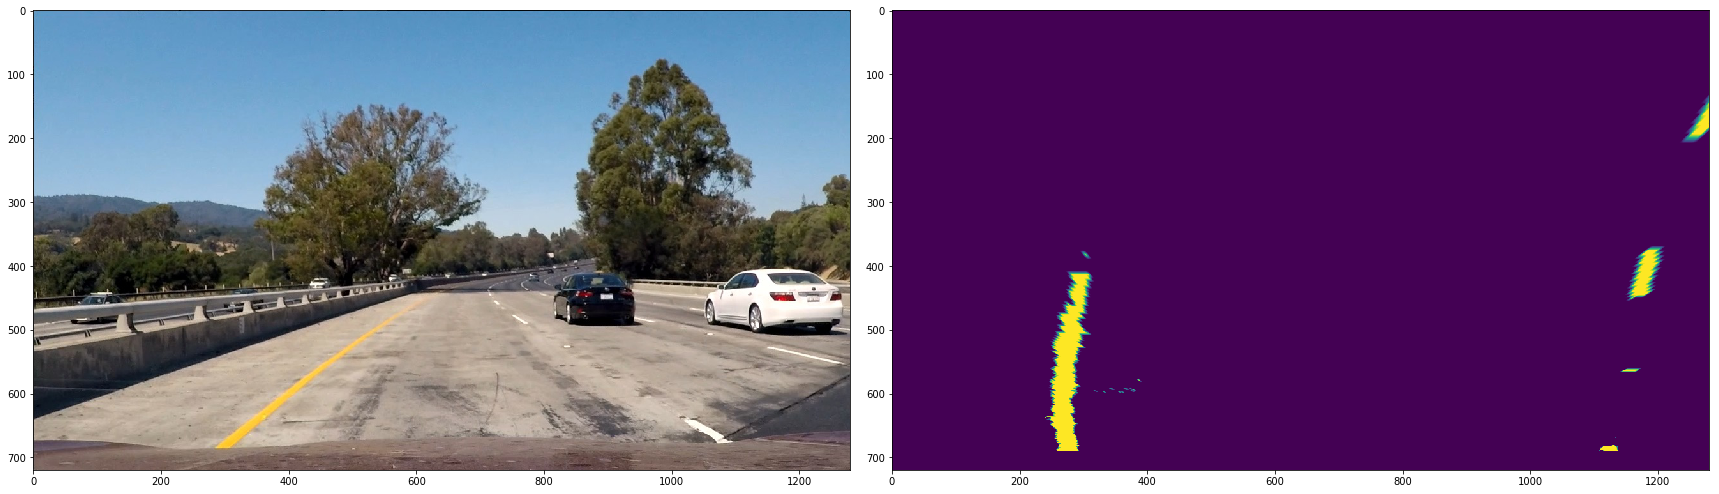

In [7]:
def find_lane_pixels(binary_warped):
    #citation: significant portions of this code is derived from the udacity course
    #create histogram to find most liekly x position for lane
    histogram = np.sum(binary_warped[binary_warped.shape[0]//3:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    working_image = np.copy(binary_warped)
    
    midpoint = np.int(histogram.shape[0]//2)
    #determine max point on left and right side
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #pick number of windows, width of margins and minimum number of pixels to recenter window on window above
    nwindows = 7
    margin = 100
    minpix = 50

    #dertermine window height
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    #identify non-zero pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #set starting point of each lane as found on histogram
    leftx_current = leftx_base
    rightx_current = rightx_base

    #initialize list for lane pixels
    left_lane_inds = []
    right_lane_inds = []

    #looping through window
    for window in range(nwindows):
        #determine left, right, top and bottom of each window
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        #identify non-zero pixels based on above boarders
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        #add non-zeros to list
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #if greater than minimum amount of pixels then realign center of next box based on mean of current box
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        test_warp_input_1 = cv2.rectangle(working_image, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (255,0,0),3)
        test_warp_input_1 = cv2.rectangle(working_image, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (255,0,0),3)

    #disect lists into one list
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        #error handling from course.  Not entirely sure why this is needed.
        pass

    #extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

img1 = mpimg.imread('test_images/test1.jpg')
img2 = cv2.undistort(img1, mtx, dist, None, mtx)
img3 = create_binary(img2)[0]
img4 = warp(img3)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img1)
ax2.imshow(img4)

In [8]:
def search_around_poly(binary_warped, leftx_r, lefty_r, rightx_r, righty_r):
    #citation: significant portions of this code is derived from the udacity course
    
    margin = 50
    
    global line1

    working_image = np.copy(binary_warped)
    
    #grab nonzero pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    
    #ensure none of the values are empty lists
    if ((len(leftx_r) == 0) or (len(lefty_r) == 0) or (len(rightx_r) == 0) or (len(righty_r) == 0)):
        print("failed, not enough points")
        return None
    
    #find left and right lane coefficents
    left_fit = np.polyfit(lefty_r, leftx_r, 2)
    right_fit = np.polyfit(righty_r, rightx_r, 2)
    
    #add non-zeros based polynomial from above + margin
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    #extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [9]:
def fit_polynomial(binary_warped, leftx, lefty, rightx, righty):
    #citation: significant portions of this code is derived from the udacity course
    #find coefficents for left and right lanes
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    
    #create y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #for every y value create an x value based on formula
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        #error handling if left or right have none values
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty

In [10]:
def measure_curvature_real(A1, B1, A2, B2):
    global line1
    #average left and right lane coefficents
    A = (A1+A2)/2
    B = (B1+B2)/2
    y = 720
    #apply equation to determine radius
    R = round((((1+(2*A*y*line1.ym_per_pix+B)**2)**(3/2))/np.absolute(2*A)),0)
    return R

In [11]:
#create line class to track values in relation to previous frames
#citation: significant portions of this code is derived from the udacity course/project tips and tricks
class Line():
    def __init__(self):
        #used to determine if it's the first frame
        self.detected = False  
        #x values of the last n fits of the line
        self.recent_leftx = []
        self.recent_lefty = []
        self.recent_rightx = []
        self.recent_righty = []
        #average x values of the fitted line over the last n iterations
        self.count = 0
        self.center_history = []
        self.leftx_history = []
        self.lefty_history = []
        self.rightx_history = []
        self.righty_history = []
        self.ym_per_pix = 0
        self.xm_per_pix = 0

In [12]:
#create line class and initalize parameters
line1 = Line()
line1.count = 0
line1.detected = False
line1.ym_per_pix = 40/720
line1.xm_per_pix = 3.7/900

def process_image_test123(img1):
    #import line1 object to be used in pipeline image
    global line1
    
    #increase line count each frame
    line1.count += 1
    
    #undistort, create a binary image and perspective transform the frame/image
    img2 = cv2.undistort(img1, mtx, dist, None, mtx)
    img3 = create_binary(img2)[0]
    img4 = warp(img3)
    
    #if it's the first frame, use the find_lane_pixels method
    if line1.count == 1:
        leftx, lefty, rightx, righty = find_lane_pixels(img4)
        line1.recent_leftx = leftx
        line1.recent_lefty = lefty
        line1.recent_rightx = rightx
        line1.recent_righty = righty

    #if it's after the first frame use the find_lane_pixels method if there are not many detected pixels
    #or use te search_around_poly if there are enough
    if line1.count > 1:
        if (len(line1.recent_leftx) < 1000) or (len(line1.recent_lefty) < 1000) or (len(line1.recent_rightx) < 1000) or (len(line1.recent_righty) < 1000):
            leftx, lefty, rightx, righty = find_lane_pixels(img4)
        else:
            leftx, lefty, rightx, righty = search_around_poly(img4, line1.recent_leftx, line1.recent_lefty, line1.recent_rightx, line1.recent_righty)

    #assign the pixels to the line1 object to be used in future method
    line1.recent_leftx = leftx
    line1.recent_lefty = lefty
    line1.recent_rightx = rightx
    line1.recent_righty = righty
    
    #find left and right lane lines using fit_polynomial
    left_fitx, right_fitx, ploty = fit_polynomial(img4, leftx, lefty, rightx, righty)

    #assign the left and right lane lines to line1 history of lane lines
    if line1.count == 1:
        line1.leftx_history = np.asarray([left_fitx])
        line1.rightx_history = np.asarray([right_fitx])
    else:
        line1.leftx_history = np.concatenate((line1.leftx_history,np.asarray([left_fitx])))
        line1.rightx_history = np.concatenate((line1.rightx_history,np.asarray([right_fitx])))

    #determine how many frames to average left and right lane lines over.  This is done to
    #smooth out the fit.  If you have one or two frames of erratic polynomials then chances are
    #the binary threshold didn't perform as well as it should have
    frame_avg = 5
    
    #delete old lane lines to maintain
    if len(line1.leftx_history) > frame_avg:
        line1.leftx_history = np.delete(line1.leftx_history,0, axis = 0)
        line1.rightx_history = np.delete(line1.rightx_history,0, axis = 0)

    #if there is only 1 history then just use that, otherwise average the values
    if len(line1.leftx_history) == 1:
        left_fitx_avg_np = line1.leftx_history[0]
        right_fitx_avg_np = line1.rightx_history[0]
    else:
        left_fitx_avg_np = np.average(line1.leftx_history, axis=0)
        right_fitx_avg_np = np.average(line1.rightx_history, axis=0)
 
    #find the new polynomical coefficents using the avgeraged lane lines and convert to meter from pixels
    A1, B1, C1 = np.polyfit(ploty*line1.ym_per_pix,left_fitx_avg_np*line1.xm_per_pix,2)
    A2, B2, C2 = np.polyfit(ploty*line1.ym_per_pix,right_fitx_avg_np*line1.xm_per_pix,2)

    #create blank image of zeros
    warp_zero = np.zeros_like(img4).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    #combine x and y values into one array looking like ((x1,y1),(x2,y2),(xn,yn))
    pts_left = np.array([np.transpose(np.vstack([left_fitx_avg_np, ploty]))])
    #do same with right lane up upside down looking like ((xn,yn),(xn-1,yn-1),...(x1,y1))
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx_avg_np , ploty])))])
    #combine top two into large array that look like (x1,y1),(x2,y2) for left....(xn,yn),(xn-1,yn-1),...(x1,y) for right
    pts = np.hstack((pts_left, pts_right))

    #citation: significant portions of the fill poly code is derived from the udacity course
    #use fillpoly to create polygon on blank image and unwarp to the orginial perspective
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    unwarped = reverse_warp(color_warp)
    
    #combine the above with the original
    result = cv2.addWeighted(img1, 1, unwarped, 0.3, 0)
    
    #determine radius based on averaged lane lines
    radius = measure_curvature_real(A1, B1, A2, B2)

    #determine x positions for left and right lanes on image
    left_cent = A1*(40)**2 + 40*B1 + C1
    right_cent = A2*(40)**2 + 40*B2 + C2

    #determine offset = (middle of lane - (center of lane))
    offset_unr = (640*line1.xm_per_pix - (left_cent + (right_cent-left_cent)/2))
    
    #convert number to rounded str that maintains signifcant digits
    #citation: this came from a few google searches
    offset = f"{(abs(offset_unr)):#.2g}"
    
    #determine if on the left or right based on positive/neg answer
    if offset_unr > 0:
        side = "right"
    else:
        side = "left"

    #apply radius and offset text to image    
    cv2.putText(result,"Radius of curvature: " + str(radius) + "(m)" ,
            org = (20, 50),fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1,color = (255, 0, 0),thickness = 2)
    cv2.putText(result,"Vehicle is: " + (offset) + "(m) " + side + " of center",
                org = (20, 100),fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1,color = (255, 0, 0),thickness = 2)
   
    return result


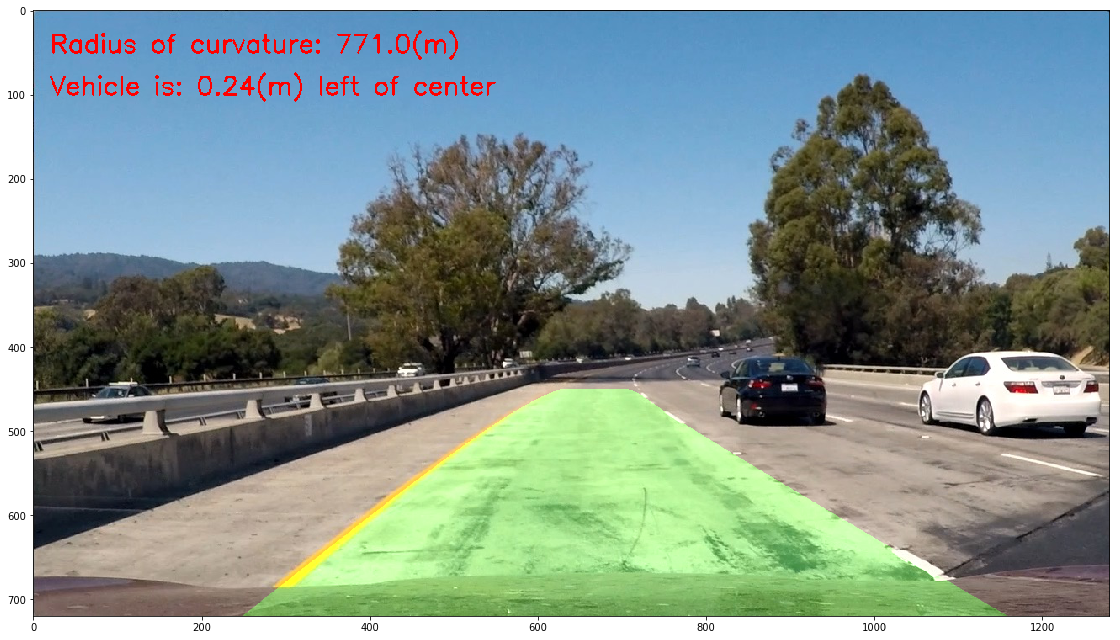

In [13]:
Finalpipeline = mpimg.imread('test_images/test1.jpg')
Finalpipeline_processed = process_image_test123(Finalpipeline)

f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()
ax1.imshow(Finalpipeline_processed)

In [107]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#.subclip(0,10)

In [108]:
final_output = 'final_output.mp4'

clip1 = VideoFileClip("project_video.mp4")
final_clip = clip1.fl_image(process_image_test123) #NOTE: this function expects color images!!
%time final_clip.write_videofile(final_output, audio=False)

[MoviePy] >>>> Building video final_output.mp4
[MoviePy] Writing video final_output.mp4


100%|█████████▉| 1260/1261 [03:27<00:00,  6.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_output.mp4 

CPU times: user 1min 23s, sys: 2.78 s, total: 1min 26s
Wall time: 3min 30s


In [109]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(final_output))